In [1]:
import torch

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Generate synthetic data
torch.manual_seed(42)
X = torch.rand(1000, 20)
y = (X.sum(dim=1) > 10).float()

# Split into train and test sets
train_X, test_X = X[:800], X[800:]
train_y, test_y = y[:800], y[800:]

In [ ]:
# Define a simple feedforward network with normalization
class NormalizedNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, use_batch_norm=True):
        super(NormalizedNetwork, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) if use_batch_norm else nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size) if use_batch_norm else nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [4]:
# Train the model
def train_model(model, train_X, train_y, test_X, test_y, epochs=20):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_X)
        loss = criterion(outputs.squeeze(), train_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(test_X)
            test_loss = criterion(test_outputs.squeeze(), test_y)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

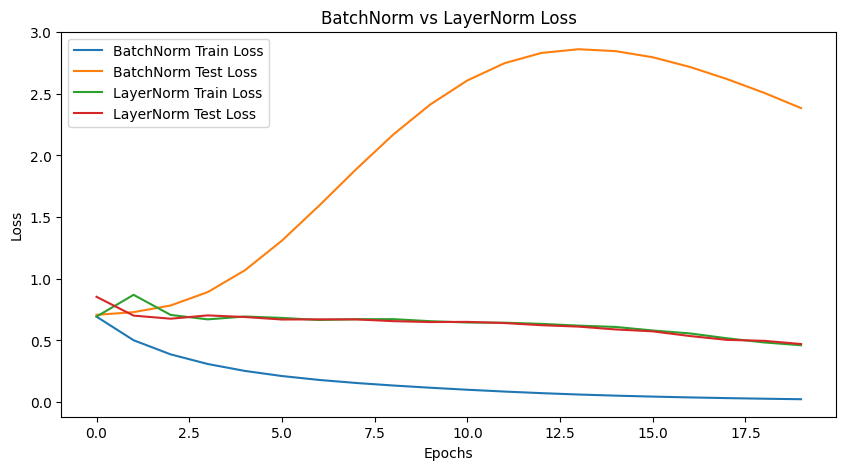

In [5]:
# Initialize models with BatchNorm and LayerNorm
batch_norm_model = NormalizedNetwork(input_size=20, hidden_size=64, use_batch_norm=True)
layer_norm_model = NormalizedNetwork(input_size=20, hidden_size=64, use_batch_norm=False)

# Train both models
batch_norm_train_losses, batch_norm_test_losses = train_model(batch_norm_model, train_X, train_y, test_X, test_y)
layer_norm_train_losses, layer_norm_test_losses = train_model(layer_norm_model, train_X, train_y, test_X, test_y)

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(batch_norm_train_losses, label='BatchNorm Train Loss')
plt.plot(batch_norm_test_losses, label='BatchNorm Test Loss')
plt.plot(layer_norm_train_losses, label='LayerNorm Train Loss')
plt.plot(layer_norm_test_losses, label='LayerNorm Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('BatchNorm vs LayerNorm Loss')
plt.show()